In [ ]:
import numpy as np 
import pandas as pd 
import os
print(os.listdir("../input"))
import keras
import h5py
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,Softmax,Input,Flatten
from keras.optimizers import Adam,RMSprop,SGD
from keras.layers.merge import add
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow import set_random_seed
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score
from keras.metrics import categorical_accuracy
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
os.environ['PYTHONHASHSEED'] = "0"
np.random.seed(1)
set_random_seed(1)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3,3), strides=(1,1), padding='same', input_shape=(64,64,1), activation='relu'))
model.add(Conv2D(32, (3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3,3), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3,3), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.60))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
__________

In [ ]:
model.compile(Adam(lr=0.0001, decay=1e-5),loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
gen = ImageDataGenerator()
train_batches = gen.flow_from_directory("../input/chest-xray-pneumonia/chest_xray/chest_xray/train",model.input_shape[1:3],color_mode="grayscale",shuffle=True,seed=1,
                                        batch_size=16)
valid_batches = gen.flow_from_directory("../input/chest-xray-pneumonia/chest_xray/chest_xray/val", model.input_shape[1:3],color_mode="grayscale", shuffle=True,seed=1,
                                        batch_size=16)
test_batches = gen.flow_from_directory("../input/chest-xray-pneumonia/chest_xray/chest_xray/test", model.input_shape[1:3], shuffle=False,
                                       color_mode="grayscale", batch_size=8)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
es = EarlyStopping(monitor='val_loss',patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)

In [ ]:
model.fit_generator(train_batches,validation_data=valid_batches,epochs=50, steps_per_epoch=16, validation_steps=16)

Epoch 1/50
16/16 [==============================] - 7s 435ms/step - loss: 0.1498 - acc: 0.9648 - val_loss: 0.4005 - val_acc: 0.8125
Epoch 2/50
16/16 [==============================] - 5s 323ms/step - loss: 0.1507 - acc: 0.9492 - val_loss: 0.1723 - val_acc: 0.9375
Epoch 3/50
16/16 [==============================] - 5s 317ms/step - loss: 0.1295 - acc: 0.9492 - val_loss: 0.1476 - val_acc: 0.9375
Epoch 4/50
16/16 [==============================] - 5s 311ms/step - loss: 0.2840 - acc: 0.9141 - val_loss: 0.5030 - val_acc: 0.6875
Epoch 5/50
16/16 [==============================] - 6s 348ms/step - loss: 0.1715 - acc: 0.9297 - val_loss: 0.4596 - val_acc: 0.7500
Epoch 6/50
16/16 [==============================] - 5s 301ms/step - loss: 0.1411 - acc: 0.9492 - val_loss: 0.9922 - val_acc: 0.5625
Epoch 7/50
16/16 [==============================] - 5s 337ms/step - loss: 0.1359 - acc: 0.9453 - val_loss: 1.8661 - val_acc: 0.5000
Epoch 8/50
16/16 [==============================] - 5s 311ms/step - loss: 0.

In [ ]:
no_steps = len(test_batches)
p = model.predict_generator(test_batches, steps=no_steps, verbose=True)
pre = pd.DataFrame(p)
pre["filename"] = test_batches.filenames
pre["label"] = (pre["filename"].str.contains("PNEUMONIA")).apply(int)
pre['pre'] = (pre[1]>0.5).apply(int)
accuracy_score(pre["label"], pre["pre"])

78/78 [==============================] - 11s 140ms/step


0.7115384615384616

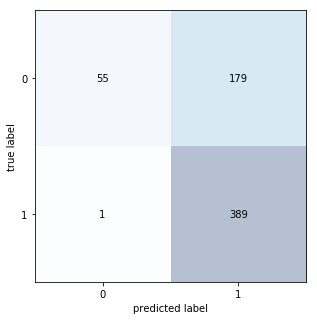

In [ ]:
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(pre["label"], pre["pre"])
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [ ]:
# Calculate Precision and Recall
tn, fp, fn, tp = CM.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 1.00
Precision of the model is 0.68
